# Supervised Learning for Best Model

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import json
import datetime
import contractions
from collections import Counter
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

/home/daniel/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
class ToPandasDF():
    def __init__(self, password, host, database, user):

        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    
    def MySQLconnect(self, query):
        
        try:
            connection = mysql.connector.connect(host=self.host, 
                                                 database=self.database, 
                                                 password=self.password,
                                                 user=self.user)

            if connection.is_connected():

                print("Successfully connected to the database\n")

                cursor = connection.cursor()
                query = query
                cursor.execute(query)

                data = cursor.fetchall()

                df = pd.DataFrame(data, columns = ['id', 'date', 'tweet'])
        except Error as e:
            print(e)
            
        cursor.close()
        connection.close()
        
        return df
    
    def check_if_valid_data(self, data):
        
        # Create a timestamp of the date(Day, Month & Year)
        data['timestamp'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
        
        if data.empty:
            print("No tweets downloaded. Finishing execution")
            
        if data['id'].unique().all():
            pass
        else:
            print(f"Primary Key check is violated, Number of duplicate values: {data.duplicated().sum()}")
            
        if data.isnull().values.any():
            print(f"\nNull values detected, Number of null: \n{data.isnull().sum()}")
        
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
        yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        timestamps = data['timestamp'].tolist()
        for timestamp in timestamps:
            if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
                print("Atleast one of the returned tweet does not come from within the last 24 hours")
        
    def basic_processing(self, data):
        data = data.drop(['date', 'timestamp'], axis=1)
        print(f'\nNumber of duplicate entry of unlabelled data: {data.tweet.duplicated().sum()}')
        # Remove duplicates
        data = data[~data.tweet.duplicated()]
        print(f'Duplicate entry removed: {data.tweet.duplicated().sum()}')
        # We will remove the usernames and RT(retweet) in the tweet column
        data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
        return data

    def load_train_data(self):
        data1 = pd.read_csv(os.path.join(config.DATAPATH, 'train.csv'))
        data2 = pd.read_csv(os.path.join(config.DATAPATH, 'HateSpeechData.csv'), index_col=0)
        data2 = data2.rename(columns={'hate_speech':'hate', 'offensive_language':'offensive',
                                      'neither':'neutral', 'class':'label'
                                     })
        # Remove all records with no label
        data1 = data1[data1.label != '']
        return data1, data2

if __name__ == '__main__':
    
    t = ToPandasDF(config.PASSWORD, config.HOST, config.DATABASE, config.USER)
    stored_data = t.MySQLconnect("SELECT id, created_at, tweet FROM `twitterdb`.`twitter_table`;")
    t.check_if_valid_data(stored_data)
    unlabelled_data = t.basic_processing(stored_data)
    data1, data2 = t.load_train_data()

Successfully connected to the database

Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the retur

In [3]:
print(unlabelled_data.shape)
unlabelled_data.info()
unlabelled_data.head(10)

(5263, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5263 entries, 0 to 6736
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5263 non-null   object
 1   tweet   5263 non-null   object
dtypes: object(2)
memory usage: 123.4+ KB


,id,tweet
0,1547971096388915211,Truth and Reconciliation Week - sign up VSB ed...
1,1547973807876345856,Uh oh she’s writing songs #inthefeels 🔪
2,1548039239316541449,#Killing white #supremacists by Bill O'Really....
3,1548287847995609092,hiya. cats are feeling fuming and accomplished...
4,1548297674062868480,If home ownership requires generational wealth...
5,1548327299304783875,THIS IS SATANIC #ZIONAZI #TORTURE STATE !\nSom...
6,1548582052240539648,#BabyFactories: sick ultimate agenda of white...
7,1548640420418273282,#Platform class kotlin.Unit #requires explicit...
8,1548681295189901317,The Let Them Eat Cake Club #Supremacists #Liar...
10,1549225465658982401,Kinda sad my bachelorette party is over 🥺#miss...


In [4]:
# 0=hate, 1=offensive, 2=neutral
print(data2.shape)
print()
print(data2.label.value_counts())
data2.info()
data2.head(10)

(24783, 6)

1    19190
2     4163
0     1430
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   count      24783 non-null  int64 
 1   hate       24783 non-null  int64 
 2   offensive  24783 non-null  int64 
 3   neutral    24783 non-null  int64 
 4   label      24783 non-null  int64 
 5   tweet      24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


,count,hate,offensive,neutral,label,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [5]:
print(data2[data2.label==1].tweet.iloc[9])
data2[['label', 'tweet']].tail(10)

" Keeks is a bitch she curves everyone " lol I walked into a conversation like this. Smh


,label,tweet
25286,1,you niggers cheat on ya gf's? smh....
25287,1,you really care bout dis bitch. my dick all in...
25288,1,"you worried bout other bitches, you need me for?"
25289,0,you're all niggers
25290,0,you're such a retard i hope you get type 2 dia...
25291,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,2,"you've gone and broke the wrong heart baby, an..."
25294,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,1,youu got wild bitches tellin you lies
25296,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [6]:
data2 = data2.copy()
data2 = data2[['label', 'tweet']]
# Create the hate and non-hate categories by combining hate and offensive categories
# 0=hate, 1=offensive, 2=neutral
data2['label'] = data2.label.replace([1], 0).replace([0], 1).replace([2], 0)
print(data2.label.value_counts())
# New label 1=hate & 0=non-hate 
data2[['label', 'tweet']].tail(10)

1    20620
0     4163
Name: label, dtype: int64


,label,tweet
25286,1,you niggers cheat on ya gf's? smh....
25287,1,you really care bout dis bitch. my dick all in...
25288,1,"you worried bout other bitches, you need me for?"
25289,1,you're all niggers
25290,1,you're such a retard i hope you get type 2 dia...
25291,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,0,"you've gone and broke the wrong heart baby, an..."
25294,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,1,youu got wild bitches tellin you lies
25296,0,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [7]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
# tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
# tfVectorizer = TfidfVectorizer(min_df=5, max_df=0.75, max_features=1000, ngram_range=(1, 2))
tfVectorizer = TfidfVectorizer(sublinear_tf=True, 
                               min_df=5, norm='l2', encoding='latin-1', max_features=1000,
                               ngram_range=(1, 2))

lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)

labelled_data = pd.concat([data1, data2], axis=0).reset_index()
labelled_data = labelled_data.drop('id', axis=1)
labelled_data = labelled_data.rename(columns={'index':'id'})
print(labelled_data.shape)
labelled_data.info()
labelled_data.head(10)

(56745, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      56745 non-null  int64 
 1   label   56745 non-null  int64 
 2   tweet   56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


,id,label,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation
5,5,0,[2/2] huge fan fare and big talking before the...
6,6,0,@user camping tomorrow @user @user @user @use...
7,7,0,the next school year is the year for exams.ð...
8,8,0,we won!!! love the land!!! #allin #cavs #champ...
9,9,0,@user @user welcome here ! i'm it's so #gr...


# Target Exploration (label)

In [8]:
labelled_data.label.value_counts()

0    33883
1    22862
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

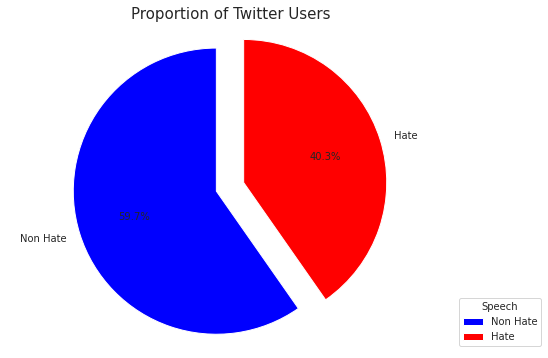

In [9]:
size=labelled_data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 40.3% of twitter users might Hate. So the baseline model could be to predict that 40.3% of the users will Hate. Given 40.3% is a small number, we need to ensure that the chosen model does predict with great accuracy this 40.3% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [10]:
def basic_prep(data):
    data['mention_count'] = data.tweet.apply(lambda x: len(re.findall(r"@[\w\-]+", x)))
    data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
    data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
    return data

def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace("nt", "not")
    return final_sent

data_cleaned = labelled_data.copy()
data_cleaned = basic_prep(data_cleaned)
data_cleaned['cleaned_text'] = data_cleaned.tweet.apply(preprocess_text)
print(f'The longest for labelled tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for labelled tweet is: {min(data_cleaned.cleaned_text.str.len())}')

unlabelled_cleaned = unlabelled_data.copy()
unlabelled_cleaned = basic_prep(unlabelled_cleaned)
unlabelled_cleaned['cleaned_text'] = unlabelled_cleaned.tweet.apply(preprocess_text)
print(f'The longest for unlabelled tweet is: {max(unlabelled_cleaned.cleaned_text.str.len())}')
print(f'The shortest for unlabelled tweet is: {min(unlabelled_cleaned.cleaned_text.str.len())}')

The longest for labelled tweet is: 339
The shortest for labelled tweet is: 0
The longest for unlabelled tweet is: 304
The shortest for unlabelled tweet is: 0


# Visualize Word frequency

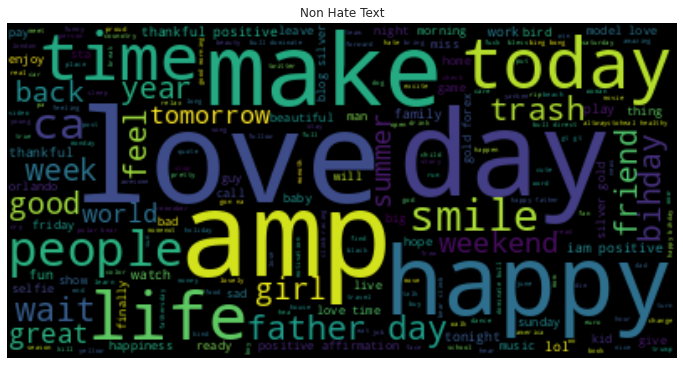

In [11]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data_cleaned['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Non Hate Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` related words**

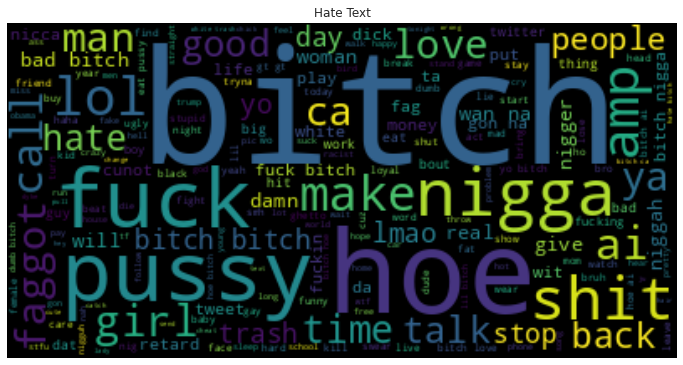

In [12]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

In [13]:
# We will encode text data using TF-IDF
def transform(data_cleaned, unlabelled_cleaned):
    tfVectorizer.fit(data_cleaned.cleaned_text)
    train_tfidf_feat = tfVectorizer.transform(data_cleaned.cleaned_text).toarray()
    unlabelled_tfidf_feat = tfVectorizer.transform(unlabelled_cleaned.cleaned_text).toarray()
    train_tfidf = pd.DataFrame(train_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    unlabelled_tfidf = pd.DataFrame(unlabelled_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    return tfVectorizer, train_tfidf, unlabelled_tfidf

def merge(tfidf, data_to_merge):
    # Join both DataFrames
    data = tfidf.merge(data_to_merge, left_index=True, right_index=True)
    data = data.drop(['cleaned_text'], axis=1)
    return data

tfVectorizer, data_train_tfidf, unlabelled_tfidf = transform(data_cleaned, unlabelled_cleaned)

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [14]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

def make_features(data):

    data['noun_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
    data['verb_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
    data['adj_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
    data['adv_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
    data['pron_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

    data['char_count'] = data.tweet.apply(len)
    data['word_count'] = data.tweet.apply(lambda x: len(x.split()))
    data['uniq_word_count'] = data.tweet.apply(lambda x: len(set(x.split())))
    data['htag_count'] = data.tweet.apply(lambda x: len(re.findall(r'#[\w\-]+', x)))
    data['stopword_count'] = data.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
    data['sent_count'] = data.tweet.apply(lambda x: len(sent_tokenize(x)))
    data['avg_word_len'] = data['char_count']/(data['word_count']+1)
    data['avg_sent_len'] = data['word_count']/(data['sent_count']+1)
    data['uniq_vs_words'] = data.uniq_word_count/(data.word_count+1) # Ratio of unique words to the total number of words
    data['stopwords_vs_words'] = data.stopword_count/(data.word_count+1)
    data['title_word_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    data['uppercase_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    data = data.drop(['id', 'tweet'], axis=1)
    return data


data_cleaned = make_features(data_cleaned)
unlabelled_cleaned = make_features(unlabelled_cleaned)

data_cleaned = merge(data_train_tfidf, data_cleaned)
unlabelled_cleaned = merge(unlabelled_tfidf, unlabelled_cleaned)

CPU times: user 5min 58s, sys: 3.71 s, total: 6min 2s
Wall time: 6min 2s


In [15]:
target_labelled_data = data_cleaned.label
data_cleaned = data_cleaned.drop(['label'], axis=1)
# unlabelled_cleaned = unlabelled_cleaned.drop('id', axis=1)
print(f"Number of columns of the data_cleaned: {data_cleaned.shape[1]}")
print(f"Number of columns of the unlabelled_cleaned: {unlabelled_cleaned.shape[1]}")
print()
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.values, target_labelled_data.values,
                                                    test_size=0.2, random_state=43)

print(f"Train Size: {(X_train.shape[0]/data_cleaned.shape[0]):.2f}%")
print(f"Test Size: {(X_test.shape[0]/data_cleaned.shape[0]):.2f}%")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unlabelled_cleaned.shape)

def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'],
                           yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

def roc_auc_curve(y_test, pred):
    plt.figure(figsize=(14, 8))
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

def train(model, scaler, X_train, y_train, X_test):
    
    """Sklearn training interface
    """
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    return pred, y_pred

Number of columns of the data_cleaned: 1018
Number of columns of the unlabelled_cleaned: 1018

Train Size: 0.80%
Test Size: 0.20%
(45396, 1018) (45396,) (11349, 1018) (11349,) (4123, 1018)


# Check for Missing Values

In [16]:
print(pd.isnull(data_cleaned).sum().sort_values(ascending=False))

about              0
police             0
pig                0
pink               0
piss               0
                  ..
friendship         0
fronot             0
fuck               0
fuck bitch         0
uppercase_count    0
Length: 1018, dtype: int64


In [17]:
print(pd.isnull(unlabelled_cleaned).sum().sort_values(ascending=False))

about              0
police             0
pig                0
pink               0
piss               0
                  ..
friendship         0
fronot             0
fuck               0
fuck bitch         0
uppercase_count    0
Length: 1018, dtype: int64


# Model Building & Evaluation

### Get the best Model to perform Pseudo-Labelling (Semi-Supervised Learning) on the unlabelled_data

## MultinomialNB & Parameter tuning

In [18]:
for a in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    pred, y_pred = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{a}->{auc:.4f}")

0.0001->0.9639
0.001->0.9640
0.01->0.9641
0.1->0.9642
1->0.9645
10->0.9655


Initial ROC AUC Naive Bayes Score before Semi-Supervised Learning: 0.9655
'%' of Misclassified class: 8.837783064587189


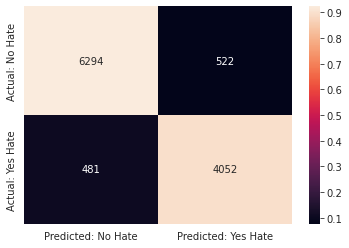

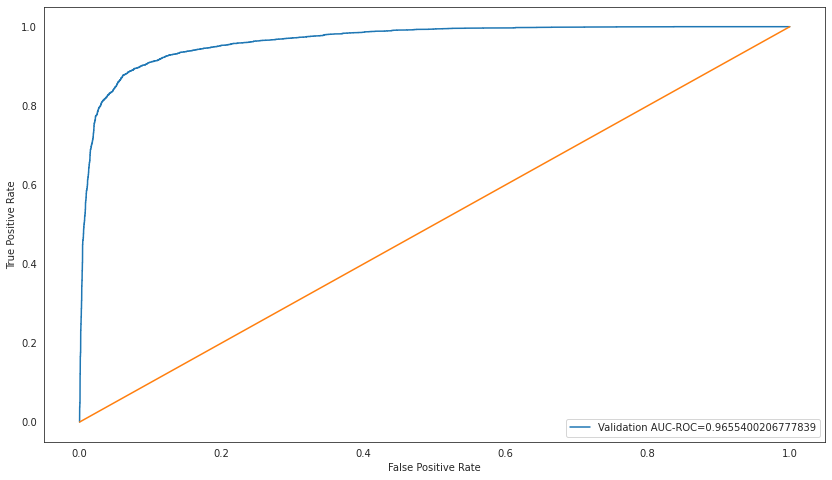

In [19]:
pred, y_pred = train(MultinomialNB(alpha=10), MinMaxScaler(), X_train, y_train, X_test)
print(f"Initial ROC AUC Naive Bayes Score before Semi-Supervised Learning: {roc_auc_score(y_test, pred):.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Logistic Regression & Parameter tuning

In [20]:
for c in [0.00005, 0.0001, 0.001, 0.01, 0.1, 1]:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=c), StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{c}->{auc:.4f}")

5e-05->0.9635
0.0001->0.9672
0.001->0.9756
0.01->0.9784
0.1->0.9785
1->0.9783


In [21]:
for m in [0.01, 0.1, 1]:
    print(f"Inverse of regularization strength C-> {m}")
    
    for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        pred, y_pred = train(LogisticRegression(solver='liblinear', C=m, tol=tol), StandardScaler(),
                             X_train, y_train, X_test)
        auc = roc_auc_score(y_test, pred)
        print(f"{tol}->{auc:.4f}")
    print()

Inverse of regularization strength C-> 0.01
1e-05->0.9784
0.0001->0.9784
0.001->0.9784
0.01->0.9784
0.1->0.9775
1->0.9709
10->0.5000

Inverse of regularization strength C-> 0.1
1e-05->0.9785
0.0001->0.9785
0.001->0.9785
0.01->0.9784
0.1->0.9776
1->0.9708
10->0.5000

Inverse of regularization strength C-> 1
1e-05->0.9783
0.0001->0.9783
0.001->0.9783
0.01->0.9784
0.1->0.9776
1->0.9708
10->0.5000



In [22]:
for mClass in ["auto", "ovr"]:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class=mClass),
                         StandardScaler(),
                         X_train, y_train, X_test)
    
    auc = roc_auc_score(y_test, pred)
    print(f"{mClass}->{auc:.4f}")

auto->0.9785
ovr->0.9785


ROC AUC Logistic Regression Score: 0.9785


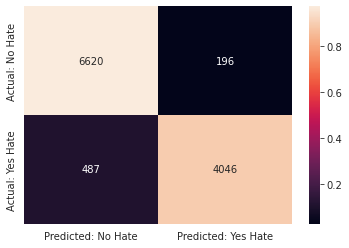

In [23]:
pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto'),
                     StandardScaler(),
                     X_train, y_train, X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

#### Apply Cost-Sensitive Logistic Regression for Imbalanced Classification

ROC AUC Logistic Regression Score: 0.9785
'%' of Misclassified class: 6.018151378976121


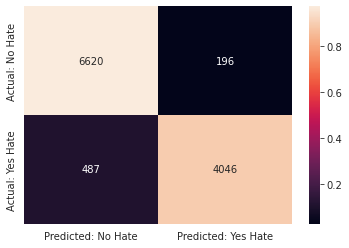

ROC AUC Logistic Regression Score: 0.9779
'%' of Misclassified class: 14.406555643669044


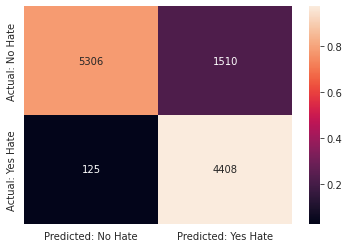

ROC AUC Logistic Regression Score: 0.9753
'%' of Misclassified class: 26.84818045642788


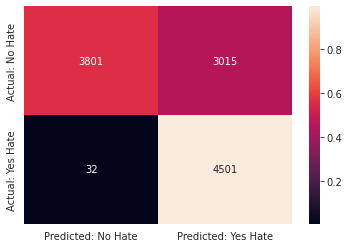

In [24]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto',
                                            class_weight=weight),
                         StandardScaler(),
                         X_train, y_train, X_test)
    print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
    print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC Logistic Regression Score: 0.9785


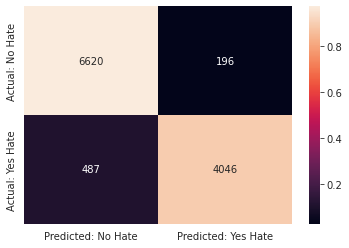

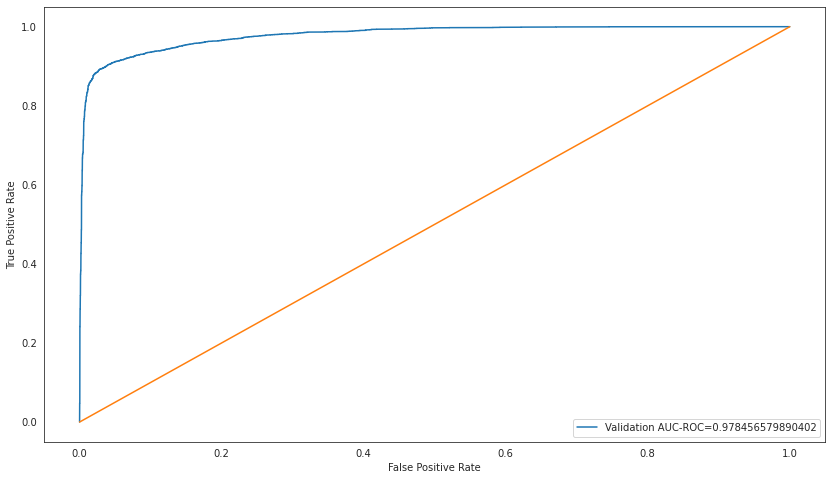

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [27]:
pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto',
                                        class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train, y_train, X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

## Random Forest & Parameter tuning

In [26]:
for n in [5, 10, 50, 200, 250, 300, 350]:
    pred, y_pred = train(RandomForestClassifier(n_estimators=n, random_state=42),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

5->0.9565
10->0.9679
50->0.9770
200->0.9785
250->0.9787
300->0.9789
350->0.9788


In [28]:
for m in [300, 350]:
    print(f"Number of estimators {m}")
    
    for c in ["gini", "entropy"]:
        pred, y_pred = train(RandomForestClassifier(n_estimators=m, criterion=c, random_state=42),
                             StandardScaler(),
                             X_train, y_train, X_test)
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Number of estimators 300
gini->0.9789
entropy->0.9789

Number of estimators 350
gini->0.9788
entropy->0.9790



In [29]:
for depth in [1, 2, 3, 4, 5]:
    pred, y_pred = train(RandomForestClassifier(n_estimators=350, criterion='entropy', 
                                                max_depth=depth),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{depth}->{auc:.4f}")

1->0.9297
2->0.9350
3->0.9353
4->0.9331
5->0.9371


ROC AUC Random Forest Classifier Score: 0.9790
'%' of Misclassified class: 6.828795488589303


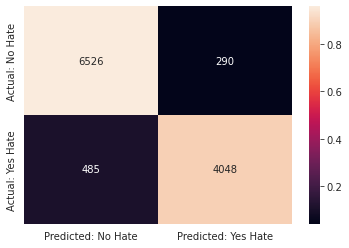

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,1,1


In [30]:
pred, y_pred = train(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                            max_depth=None, class_weight={0:1,1:100}, random_state=42),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

ROC AUC Random Forest Classifier Score: 0.9790
'%' of Misclassified class: 6.546832320028197


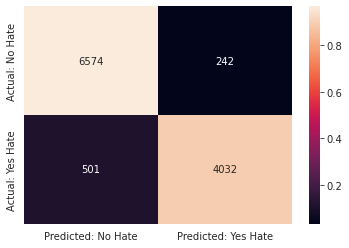

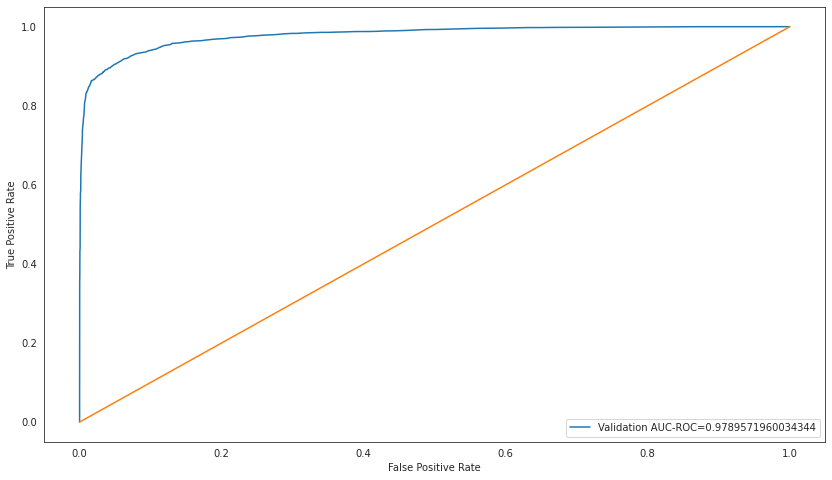

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,1,1


In [31]:
pred, y_pred = train(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                            max_depth=None, random_state=42),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

## LGMClassifier & Parameter tuning

In [32]:
for n in [25, 50, 100, 150, 200, 250, 300, 350, 400]:
    pred, y_pred = train(LGBMClassifier(n_estimators=n, objective='binary'),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

25->0.9705
50->0.9773
100->0.9812
150->0.9821
200->0.9826
250->0.9828
300->0.9828
350->0.9828
400->0.9828


In [33]:
for alpha in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
    pred, y_pred = train(LGBMClassifier(n_estimators=250, objective='binary', reg_alpha=alpha),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{alpha}->{auc:.4f}")

0.001->0.9826
0.01->0.9829
0.1->0.9828
1->0.9825
1.5->0.9822
2->0.9824
2.5->0.9818


In [34]:
for lr in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
    pred, y_pred = train(LGBMClassifier(n_estimators=250, objective='binary', 
                                        reg_alpha=0.01, learning_rate=lr),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.001->0.9570
0.01->0.9711
0.1->0.9829
1->0.8451
1.5->0.6380
2->0.5273
2.5->0.6449


ROC AUC LGBM Classifier Score: 0.9829


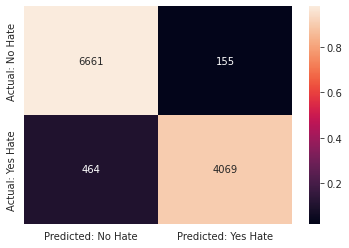

In [35]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, reg_alpha=0.01, learning_rate=0.1, objective='binary'),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

ROC AUC LGBM Classifier Score: 0.9829
'%' of Misclassified class: 5.454225041853908


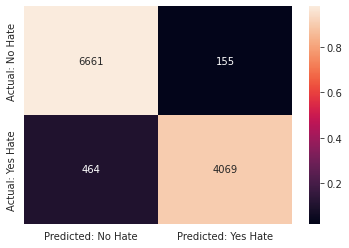

ROC AUC LGBM Classifier Score: 0.9823
'%' of Misclassified class: 11.14635650718125


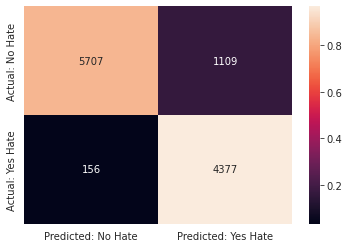

ROC AUC LGBM Classifier Score: 0.9800
'%' of Misclassified class: 20.51282051282051


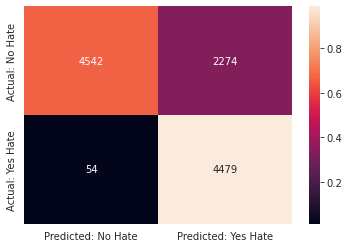

In [36]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    pred, y_pred = train(LGBMClassifier(n_estimators=250, reg_alpha=0.01, learning_rate=0.1, objective='binary',
                                        class_weight=weight),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
    print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC LGBM Classifier Score: 0.9829
'%' of Misclassified class: 5.454225041853908


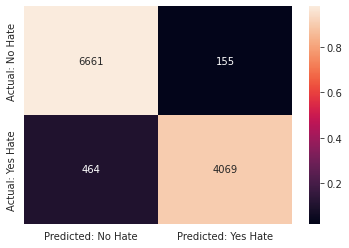

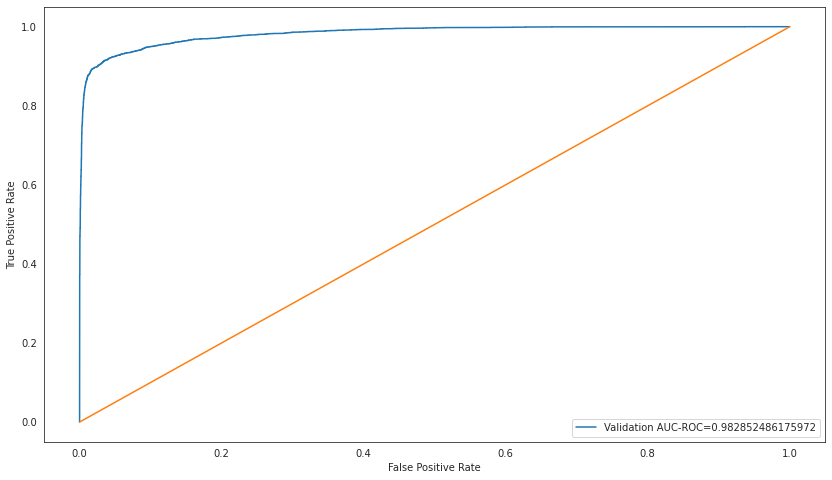

In [32]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, reg_alpha=0.01, learning_rate=0.1, objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

## XGBoost Classifier & Parameter tuning

In [38]:
for n in [200, 250, 300, 350]:
    pred, y_pred = train(XGBClassifier(n_estimators=n, eval_metric="auc", 
                                       objective='binary:logistic'),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

200->0.9820
250->0.9824
300->0.9826
350->0.9827


In [39]:
for lr in [0.0001, 0.001, 0.1, 1, 1.5]:
    pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                       objective='binary:logistic', learning_rate=lr),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.0001->0.9177
0.001->0.9213
0.1->0.9809
1->0.9765
1.5->0.9678


ROC AUC XGBoost Classifier Score: 0.9827


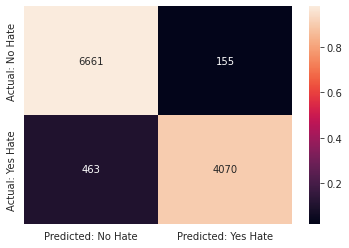

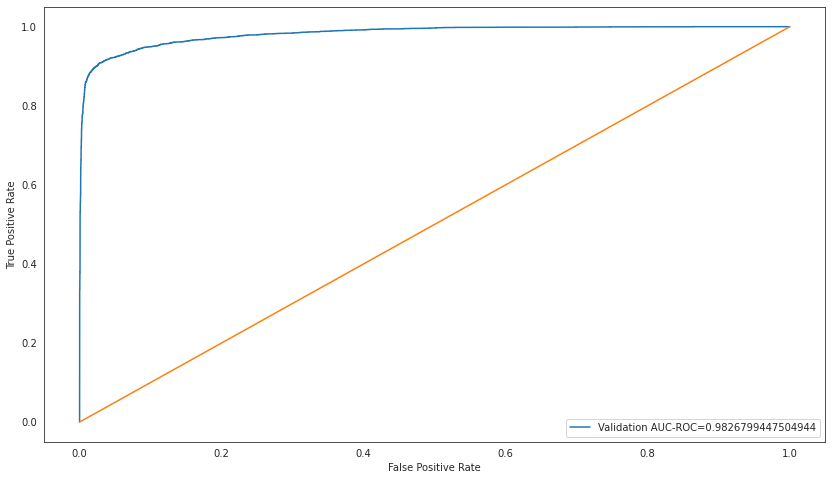

In [40]:
pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

The LGBMClassifer has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [41]:
def cross_validation_score(ml_model, scaler, thres = 0.5, random_st=42, cols = data_cleaned.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = data_cleaned.copy()
    x1 = data_cleaned[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        pipeline = make_pipeline(scaler, model)
        pipeline.fit(xtrain, ytrain)
        y_pred = pipeline.predict(xval)
        pred_probs = pipeline.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Multinomial NB

In [42]:
y=target_labelled_data
nb_cv_score = cross_validation_score(MultinomialNB(alpha=10), MinMaxScaler())


1 of KFold 5
ROC AUC Score: 0.9619, Recall Score: 0.8841, Precision Score: 0.8821

2 of KFold 5
ROC AUC Score: 0.9633, Recall Score: 0.8841, Precision Score: 0.8921

3 of KFold 5
ROC AUC Score: 0.9652, Recall Score: 0.8948, Precision Score: 0.8870

4 of KFold 5
ROC AUC Score: 0.9660, Recall Score: 0.9025, Precision Score: 0.8889

5 of KFold 5
ROC AUC Score: 0.9608, Recall Score: 0.8769, Precision Score: 0.8777


## Logistic Regression

In [43]:
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear', 
                                                         C=0.1, tol=1e-05, 
                                                         multi_class='auto',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9773, Recall Score: 0.8845, Precision Score: 0.9513

2 of KFold 5
ROC AUC Score: 0.9778, Recall Score: 0.8928, Precision Score: 0.9524

3 of KFold 5
ROC AUC Score: 0.9794, Recall Score: 0.8983, Precision Score: 0.9538

4 of KFold 5
ROC AUC Score: 0.9793, Recall Score: 0.8959, Precision Score: 0.9504

5 of KFold 5
ROC AUC Score: 0.9760, Recall Score: 0.8863, Precision Score: 0.9532


## RandomForestClassifier

In [44]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                                            max_depth=None, random_state=42),
                                     StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9772, Recall Score: 0.8882, Precision Score: 0.9471

2 of KFold 5
ROC AUC Score: 0.9795, Recall Score: 0.8909, Precision Score: 0.9485

3 of KFold 5
ROC AUC Score: 0.9821, Recall Score: 0.8983, Precision Score: 0.9520

4 of KFold 5
ROC AUC Score: 0.9803, Recall Score: 0.8953, Precision Score: 0.9508

5 of KFold 5
ROC AUC Score: 0.9768, Recall Score: 0.8885, Precision Score: 0.9504


## LGBMClassifier

In [46]:
lgm_cv_score = cross_validation_score(LGBMClassifier(n_estimators=250, 
                                                     reg_alpha=0.01,
                                                     learning_rate=0.1,
                                                     objective='binary',
                                                     class_weight={0:1,1:1}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.8878, Precision Score: 0.9662

2 of KFold 5
ROC AUC Score: 0.9828, Recall Score: 0.8992, Precision Score: 0.9634

3 of KFold 5
ROC AUC Score: 0.9849, Recall Score: 0.9044, Precision Score: 0.9693

4 of KFold 5
ROC AUC Score: 0.9840, Recall Score: 0.9005, Precision Score: 0.9658

5 of KFold 5
ROC AUC Score: 0.9813, Recall Score: 0.8918, Precision Score: 0.9682


## XGBClassifier

In [47]:
xgb_cv_score = cross_validation_score(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                                    objective='binary:logistic'),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9811, Recall Score: 0.8917, Precision Score: 0.9609

2 of KFold 5
ROC AUC Score: 0.9821, Recall Score: 0.8987, Precision Score: 0.9618

3 of KFold 5
ROC AUC Score: 0.9842, Recall Score: 0.9027, Precision Score: 0.9661

4 of KFold 5
ROC AUC Score: 0.9841, Recall Score: 0.9018, Precision Score: 0.9647

5 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.8944, Precision Score: 0.9658


# Comparison of Model Fold wise

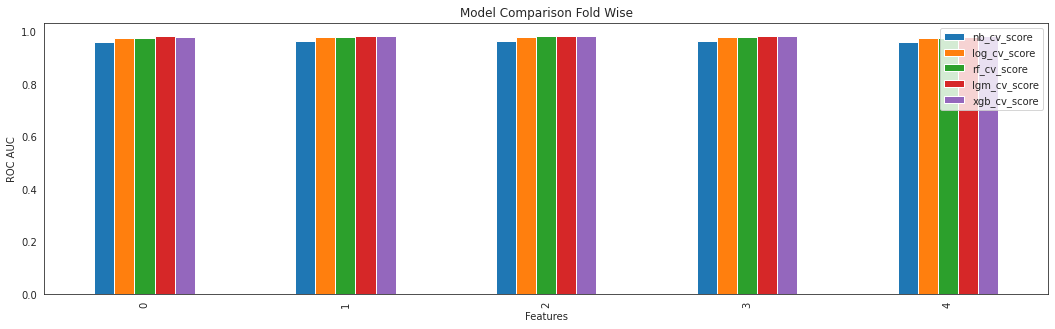

In [48]:
compare_score = pd.DataFrame({'nb_cv_score':nb_cv_score,
                              'log_cv_score':log_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'lgm_cv_score':lgm_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['nb_cv_score','log_cv_score','rf_cv_score',
                        'lgm_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `LGBM Model` has the best performance across 5-fold. Therefore, we will work on improving it.**

In [49]:
lgb_model = make_pipeline(StandardScaler(), LGBMClassifier(n_estimators=250, 
                                                           reg_alpha=0.01,
                                                           learning_rate=0.1,
                                                           objective='binary',
                                                           class_weight={0:1,1:1}))

lgb_model.fit(X_train, y_train)

step_factor = 0.02
threshold_value = 0.1
roc_score = 0
proba = lgb_model.predict_proba(X_test)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.1->0.8939630988556532
Threshold: 0.12000000000000001->0.9066110067641676
Threshold: 0.14->0.9141956928533477
Threshold: 0.16->0.919325863076096
Threshold: 0.18->0.9236121629956221
Threshold: 0.19999999999999998->0.9269817698380888
Threshold: 0.21999999999999997->0.9282952499355276
Threshold: 0.23999999999999996->0.9301618432745157
Threshold: 0.25999999999999995->0.932432166071656
Threshold: 0.27999999999999997->0.9345557752537728
Threshold: 0.3->0.9361294753963889
Threshold: 0.32->0.9372625006602597
Threshold: 0.34->0.9388736802571439
Threshold: 0.36000000000000004->0.9393839737076772
Threshold: 0.38000000000000006->0.9390118493333707
Threshold: 0.4000000000000001->0.9391558927800201
Threshold: 0.4200000000000001->0.9387848364730631
Threshold: 0.4400000000000001->0.9379361598667674
Threshold: 0.46000000000000013->0.9377492966291019
Threshold: 0.48000000000000015->0.9372690061613893
Threshold: 0.5000000000000001->0.9374494609949572
Threshold: 0.5200000000000001->0.937630449

In [50]:
cross_validation_score(LGBMClassifier(n_estimators=250, 
                                      reg_alpha=0.01,
                                      learning_rate=0.1,
                                      objective='binary',
                                      class_weight={0:1,1:1}),
                       StandardScaler(), thres=0.36)


1 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.9084, Precision Score: 0.9390

2 of KFold 5
ROC AUC Score: 0.9828, Recall Score: 0.9147, Precision Score: 0.9370

3 of KFold 5
ROC AUC Score: 0.9849, Recall Score: 0.9217, Precision Score: 0.9446

4 of KFold 5
ROC AUC Score: 0.9840, Recall Score: 0.9171, Precision Score: 0.9385

5 of KFold 5
ROC AUC Score: 0.9813, Recall Score: 0.9079, Precision Score: 0.9473


[0.9815020724593283,
 0.9827641896688544,
 0.9848852540326365,
 0.9839785187478168,
 0.9813013656720792]

There is no improvement in the recall score. There was no improvement in the recall till after we gathered more data which improved the roc across all model.

**Ways to improve this model**
1. Add more training data
2. Try Over/Undersampling techniques like SMOTE

**My approach to Semi-Supervised Learning**

1. Select the best model after Supervised learning which is the LGBMClassifer
2. Try to improve the model with different SMOTE techniques
3. Select the SMOTE with low '%' of Misclassification
4. Train model with SMOTE training data if the '%' of Misclassification is lower than the original training data
5. Perform Pseudo Labelling on with the best model
6. Select a better confidence/probability value via the graph with the new training data.
7. Training the model with the new training data based on the confidence.
8. Do step 2,3 and 4.
9. Store model for deployment.

# Addressing Imbalanced Class with SMOTE

In [16]:
print(X_train.shape)
print(y_train.shape)
print()
print(Counter(y_train))

(45396, 1018)
(45396,)

Counter({0: 27067, 1: 18329})


In [18]:
X_train_ada, y_train_ada = ADASYN(random_state = 154).fit_resample(X_train, y_train)
print(X_train_ada.shape)
print(y_train_ada.shape)
print(Counter(y_train_ada))

(54451, 1018)
(54451,)
Counter({1: 27384, 0: 27067})


ROC AUC LGBMClassifier Score with ADASYN: 0.9830
'%' of Misclassified class: 5.330866155608423


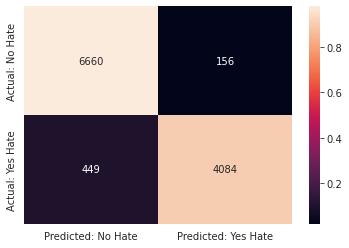

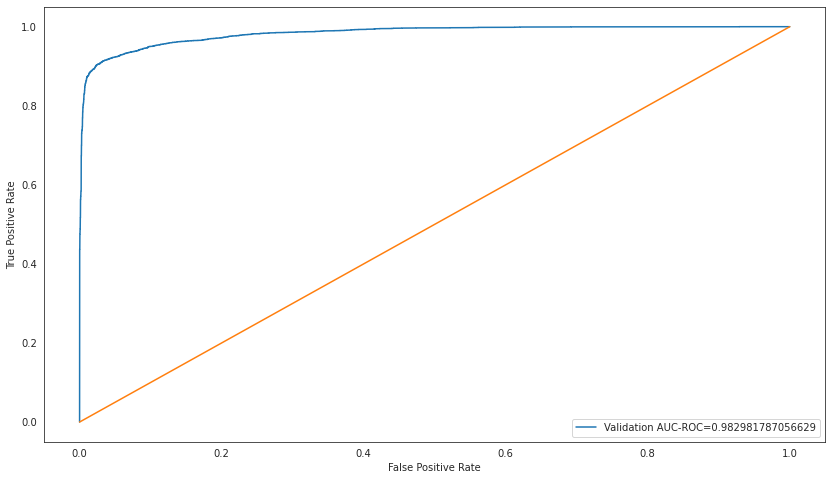

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [19]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train_ada, y_train_ada, X_test)

auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBMClassifier Score with ADASYN: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

(54134, 1018)
(54134,)
Counter({0: 27067, 1: 27067})
ROC AUC LGBMClassifier Score with BorderlineSMOTE: 0.9828
'%' of Misclassified class: 5.374922900696097


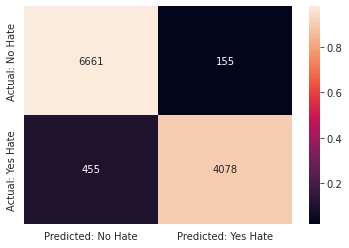

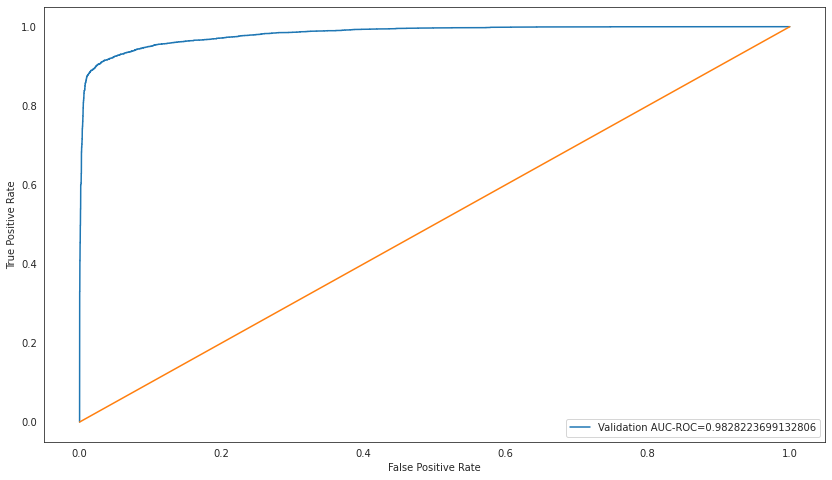

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [19]:
X_train_bls, y_train_bls = BorderlineSMOTE(random_state = 154).fit_resample(X_train, y_train)
print(X_train_bls.shape)
print(y_train_bls.shape)
print(Counter(y_train_bls))

pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train_bls, y_train_bls, X_test)

auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBMClassifier Score with BorderlineSMOTE: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [46]:
smote_pipe = Pipeline([('over', SMOTE(random_state = 11, sampling_strategy=0.8)),
                     ('under', RandomUnderSampler(sampling_strategy=0.9))]
                   )

X_train_sm, y_train_sm = smote_pipe.fit_resample(X_train, y_train)
print(X_train_sm.shape)
print(y_train_sm.shape)
print()
print(Counter(y_train_sm))

(45711, 1018)
(45711,)

Counter({0: 24058, 1: 21653})


ROC AUC LGBMClassifier Score with SMOTE: 0.9827
'%' of Misclassified class: 5.454225041853908


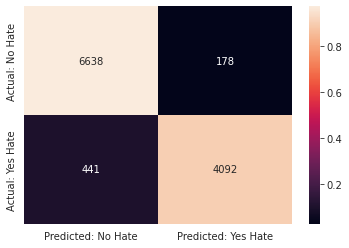

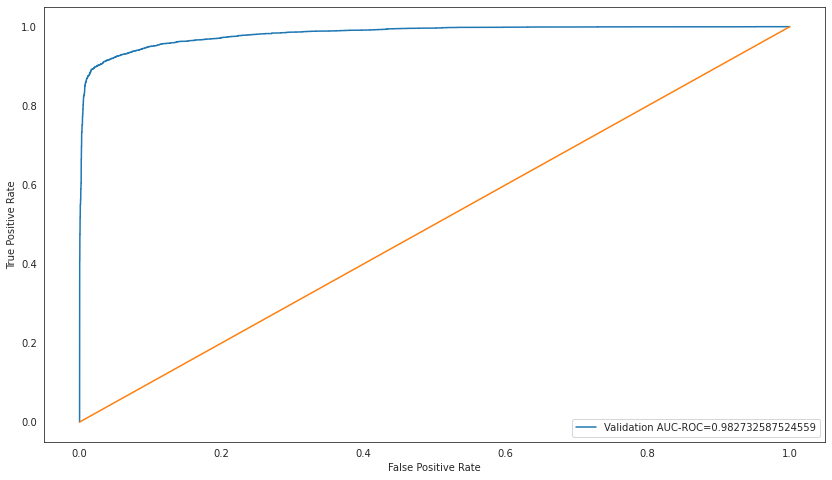

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [47]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test)

auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBMClassifier Score with SMOTE: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

**We will train the model for psuedo-model with the ADASYN data, because of the low '%' of Misclassified class though the roc score came down a bit. For imbalance problem accuracy/roc score is not essential as compared to the '%' of Misclassified class.**

# Semi-Supervised Learning

**Goal:** Is to develop a Pseudo-labeling approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

ROC AUC LGBClassifer Score before Semi-Supervised Learning: 0.9830
'%' of Misclassified class: 5.330866155608423


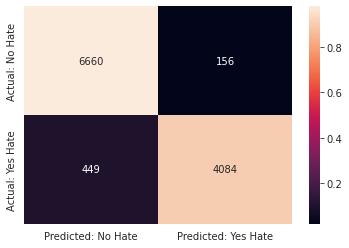

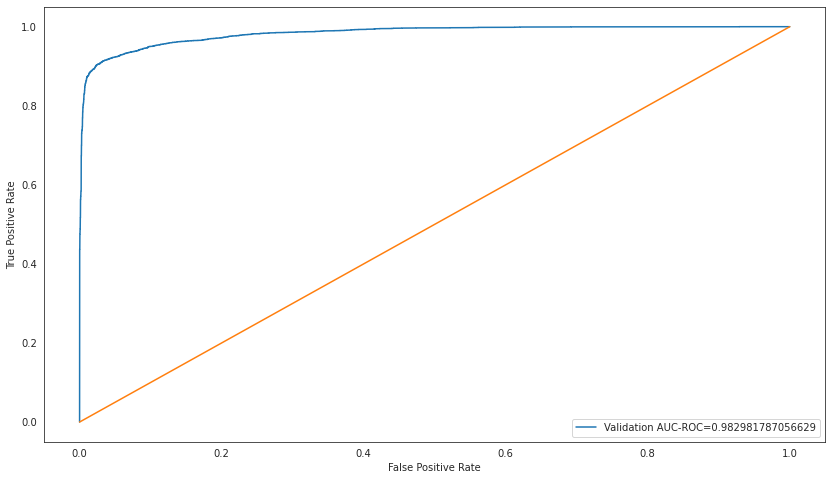

In [20]:
semi_sup_model = make_pipeline(StandardScaler(), LGBMClassifier(n_estimators=250, 
                                                                reg_alpha=0.01,
                                                                learning_rate=0.1,
                                                                objective='binary',
                                                                class_weight={0:1,1:1}))
semi_sup_model.fit(X_train_ada, y_train_ada)
pred = semi_sup_model.predict_proba(X_test)[:, 1]
y_pred = semi_sup_model.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBClassifer Score before Semi-Supervised Learning: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

In [21]:
unlabelled_cleaned = unlabelled_cleaned.values
probs = semi_sup_model.predict_proba(unlabelled_cleaned)
preds = semi_sup_model.predict(unlabelled_cleaned)

df_pseudo = pd.DataFrame(probs, columns = ['C1Prob', 'C2Prob']) 
df_pseudo['lab']=preds
df_pseudo['max']=df_pseudo[["C1Prob", "C2Prob"]].max(axis=1)

In [22]:
# Ensure the datatype are all in numpy arrays
print(type(X_train), type(y_train), type(X_test), type(y_test), type(unlabelled_cleaned))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [23]:
print(f"Unlabelled length -> {unlabelled_cleaned.shape[0]}")
print(f"Pseudo length -> {df_pseudo.shape[0]}")
df_pseudo.head()

Unlabelled length -> 4123
Pseudo length -> 4123


,C1Prob,C2Prob,lab,max
0,0.790647,0.209353,0,0.790647
1,0.708354,0.291646,0,0.708354
2,0.515176,0.484824,0,0.515176
3,0.994604,0.005396,0,0.994604
4,0.846210,0.153790,0,0.846210


## Plotting the Confidence

The below graph gives the distribution of confidence as expressed by the probability of the class which is most probable.

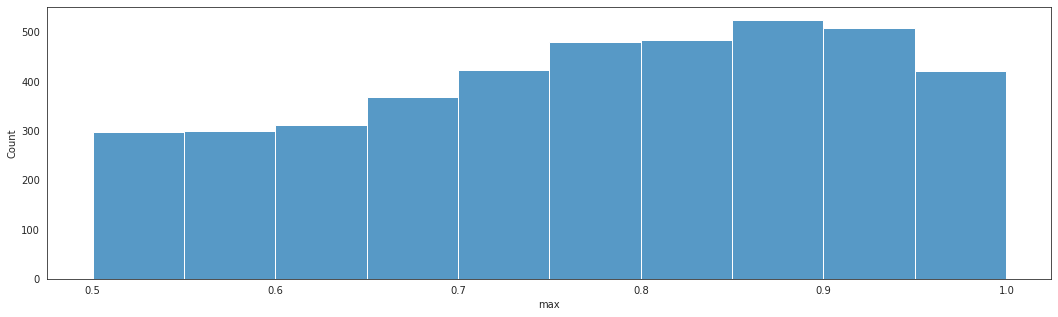

In [24]:
sns.histplot(data = df_pseudo, x = 'max', bins=10)
plt.show()

In [25]:
def check_score(model, scaler, X_train, y_train, X_test, y_test):
    
    """Function to confirm the confidence that best fit the data
    """
    print(f"Old Train Data shape: {X_train.shape[0]} \nOld Train label shape: {y_train.shape[0]}\n")
    nc=np.arange(.5,1,0.001)
    # print(len(nc))
    auc_scores=np.empty(len(nc))
    i=0
    for k in np.nditer(nc):
        conf_ind=df_pseudo["max"]>k
        X_new = np.append(X_train, unlabelled_cleaned[conf_ind,:],axis=0)
        y_new = np.append(y_train, df_pseudo.loc[conf_ind, ['lab']])
        test_model = make_pipeline(scaler, model)
        test_model.fit(X_new, y_new)
        pred = test_model.predict_proba(X_test)[:, 1]
        y_pred = test_model.predict(X_test)
        print(f"Iteration-> {i}")
        print(f"New Train Data shape: {X_new.shape[0]} \nNew Train label shape: {y_new.shape[0]}\n")
        # print(f"New Train instances remaining-> {len(X_new)}")
        print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
        auc_scores[i] = roc_auc_score(y_test, pred)
        print(f"{k}->{roc_auc_score(y_test, pred)}")
        print()
        i += 1
    return auc_scores, nc

def conf_and_roc_plot(auc, nc):
    compare=pd.Series(auc, index=nc)
    compare.plot()
    plt.title('Confidence vs ROC')
    plt.xlabel('Confidence')
    plt.ylabel('ROC Score')
    plt.show()

In [26]:
auc_scores, nc = check_score(LGBMClassifier(n_estimators=250, 
                                            reg_alpha=0.01,
                                            learning_rate=0.1,
                                            objective='binary',
                                            class_weight={0:1,1:1}), StandardScaler(),
                             X_train, y_train, X_test, y_test)

Old Train Data shape: 45396 
Old Train label shape: 45396

Iteration-> 0
New Train Data shape: 49519 
New Train label shape: 49519

'%' of Misclassified class: 5.410168296766235
0.5->0.9823383735755218

Iteration-> 1
New Train Data shape: 49514 
New Train label shape: 49514

'%' of Misclassified class: 5.383734249713632
0.501->0.9824697944080396

Iteration-> 2
New Train Data shape: 49511 
New Train label shape: 49511

'%' of Misclassified class: 5.471847739888977
0.502->0.9822379914274972

Iteration-> 3
New Train Data shape: 49507 
New Train label shape: 49507

'%' of Misclassified class: 5.374922900696097
0.503->0.9822203359505516

Iteration-> 4
New Train Data shape: 49503 
New Train label shape: 49503

'%' of Misclassified class: 5.366111551678562
0.504->0.9824783551296751

Iteration-> 5
New Train Data shape: 49493 
New Train label shape: 49493

'%' of Misclassified class: 5.313243457573354
0.505->0.9822630262788585

Iteration-> 6
New Train Data shape: 49490 
New Train label shape: 4

Iteration-> 56
New Train Data shape: 49190 
New Train label shape: 49190

'%' of Misclassified class: 5.383734249713632
0.556->0.9819473961942107

Iteration-> 57
New Train Data shape: 49184 
New Train label shape: 49184

'%' of Misclassified class: 5.286809410520751
0.557->0.9824316514573876

Iteration-> 58
New Train Data shape: 49177 
New Train label shape: 49177

'%' of Misclassified class: 5.366111551678562
0.558->0.9821662690866871

Iteration-> 59
New Train Data shape: 49170 
New Train label shape: 49170

'%' of Misclassified class: 5.436602343818839
0.559->0.9822353212591233

Iteration-> 60
New Train Data shape: 49164 
New Train label shape: 49164

'%' of Misclassified class: 5.357300202661027
0.56->0.9822313240979815

Iteration-> 61
New Train Data shape: 49159 
New Train label shape: 49159

'%' of Misclassified class: 5.410168296766235
0.561->0.9821763348123154

Iteration-> 62
New Train Data shape: 49151 
New Train label shape: 49151

'%' of Misclassified class: 5.366111551678562

Iteration-> 108
New Train Data shape: 48873 
New Train label shape: 48873

'%' of Misclassified class: 5.357300202661027
0.6080000000000001->0.9824454554187394

Iteration-> 109
New Train Data shape: 48866 
New Train label shape: 48866

'%' of Misclassified class: 5.445413692836373
0.6090000000000001->0.9823621461654699

Iteration-> 110
New Train Data shape: 48855 
New Train label shape: 48855

'%' of Misclassified class: 5.383734249713632
0.6100000000000001->0.9820649321511835

Iteration-> 111
New Train Data shape: 48849 
New Train label shape: 48849

'%' of Misclassified class: 5.427790994801304
0.6110000000000001->0.9822119856058182

Iteration-> 112
New Train Data shape: 48845 
New Train label shape: 48845

'%' of Misclassified class: 5.454225041853908
0.6120000000000001->0.9822902458134349

Iteration-> 113
New Train Data shape: 48840 
New Train label shape: 48840

'%' of Misclassified class: 5.427790994801304
0.6130000000000001->0.9822275049480648

Iteration-> 114
New Train Data sha

Iteration-> 159
New Train Data shape: 48544 
New Train label shape: 48544

'%' of Misclassified class: 5.436602343818839
0.6590000000000001->0.9822018875145129

Iteration-> 160
New Train Data shape: 48537 
New Train label shape: 48537

'%' of Misclassified class: 5.30443210855582
0.6600000000000001->0.9822718135602349

Iteration-> 161
New Train Data shape: 48531 
New Train label shape: 48531

'%' of Misclassified class: 5.392545598731166
0.6610000000000001->0.9823265115548058

Iteration-> 162
New Train Data shape: 48525 
New Train label shape: 48525

'%' of Misclassified class: 5.427790994801304
0.6620000000000001->0.9825103809673248

Iteration-> 163
New Train Data shape: 48517 
New Train label shape: 48517

'%' of Misclassified class: 5.3484888536434925
0.6630000000000001->0.9826475305247175

Iteration-> 164
New Train Data shape: 48512 
New Train label shape: 48512

'%' of Misclassified class: 5.30443210855582
0.6640000000000001->0.9819993431062144

Iteration-> 165
New Train Data shap

Iteration-> 210
New Train Data shape: 48154 
New Train label shape: 48154

'%' of Misclassified class: 5.3484888536434925
0.7100000000000002->0.9820589445008902

Iteration-> 211
New Train Data shape: 48149 
New Train label shape: 48149

'%' of Misclassified class: 5.330866155608423
0.7110000000000002->0.9824771252339392

Iteration-> 212
New Train Data shape: 48142 
New Train label shape: 48142

'%' of Misclassified class: 5.454225041853908
0.7120000000000002->0.9824755878642693

Iteration-> 213
New Train Data shape: 48131 
New Train label shape: 48131

'%' of Misclassified class: 5.4630363908714425
0.7130000000000002->0.9824629328844604

Iteration-> 214
New Train Data shape: 48124 
New Train label shape: 48124

'%' of Misclassified class: 5.436602343818839
0.7140000000000002->0.982283012084567

Iteration-> 215
New Train Data shape: 48116 
New Train label shape: 48116

'%' of Misclassified class: 5.471847739888977
0.7150000000000002->0.982426553863219

Iteration-> 216
New Train Data sha

Iteration-> 261
New Train Data shape: 47713 
New Train label shape: 47713

'%' of Misclassified class: 5.295620759538285
0.7610000000000002->0.9825834464837411

Iteration-> 262
New Train Data shape: 47702 
New Train label shape: 47702

'%' of Misclassified class: 5.366111551678562
0.7620000000000002->0.9822704218361127

Iteration-> 263
New Train Data shape: 47695 
New Train label shape: 47695

'%' of Misclassified class: 5.357300202661027
0.7630000000000002->0.9824395648654778

Iteration-> 264
New Train Data shape: 47686 
New Train label shape: 47686

'%' of Misclassified class: 5.330866155608423
0.7640000000000002->0.9823150541050554

Iteration-> 265
New Train Data shape: 47678 
New Train label shape: 47678

'%' of Misclassified class: 5.392545598731166
0.7650000000000002->0.9821820959028678

Iteration-> 266
New Train Data shape: 47669 
New Train label shape: 47669

'%' of Misclassified class: 5.489470437924046
0.7660000000000002->0.9826272210622363

Iteration-> 267
New Train Data sha

Iteration-> 312
New Train Data shape: 47215 
New Train label shape: 47215

'%' of Misclassified class: 5.313243457573354
0.8120000000000003->0.982606960148271

Iteration-> 313
New Train Data shape: 47206 
New Train label shape: 47206

'%' of Misclassified class: 5.313243457573354
0.8130000000000003->0.9823574369594285

Iteration-> 314
New Train Data shape: 47191 
New Train label shape: 47191

'%' of Misclassified class: 5.392545598731166
0.8140000000000003->0.9823274501594463

Iteration-> 315
New Train Data shape: 47184 
New Train label shape: 47184

'%' of Misclassified class: 5.383734249713632
0.8150000000000003->0.9823190350833585

Iteration-> 316
New Train Data shape: 47167 
New Train label shape: 47167

'%' of Misclassified class: 5.392545598731166
0.8160000000000003->0.9824342407115685

Iteration-> 317
New Train Data shape: 47162 
New Train label shape: 47162

'%' of Misclassified class: 5.41897964578377
0.8170000000000003->0.9824196761568011

Iteration-> 318
New Train Data shape

Iteration-> 363
New Train Data shape: 46703 
New Train label shape: 46703

'%' of Misclassified class: 5.410168296766235
0.8630000000000003->0.982547763324561

Iteration-> 364
New Train Data shape: 46694 
New Train label shape: 46694

'%' of Misclassified class: 5.330866155608423
0.8640000000000003->0.9824371698053606

Iteration-> 365
New Train Data shape: 46683 
New Train label shape: 46683

'%' of Misclassified class: 5.41897964578377
0.8650000000000003->0.9825155271100092

Iteration-> 366
New Train Data shape: 46677 
New Train label shape: 46677

'%' of Misclassified class: 5.295620759538285
0.8660000000000003->0.9825649009506705

Iteration-> 367
New Train Data shape: 46663 
New Train label shape: 46663

'%' of Misclassified class: 5.366111551678562
0.8670000000000003->0.9827191395856572

Iteration-> 368
New Train Data shape: 46648 
New Train label shape: 46648

'%' of Misclassified class: 5.410168296766235
0.8680000000000003->0.9827154175327723

Iteration-> 369
New Train Data shape

Iteration-> 414
New Train Data shape: 46172 
New Train label shape: 46172

'%' of Misclassified class: 5.392545598731166
0.9140000000000004->0.9827014193773569

Iteration-> 415
New Train Data shape: 46163 
New Train label shape: 46163

'%' of Misclassified class: 5.401356947748701
0.9150000000000004->0.9828332933293563

Iteration-> 416
New Train Data shape: 46153 
New Train label shape: 46153

'%' of Misclassified class: 5.445413692836373
0.9160000000000004->0.9828415627598963

Iteration-> 417
New Train Data shape: 46140 
New Train label shape: 46140

'%' of Misclassified class: 5.427790994801304
0.9170000000000004->0.9827181686153393

Iteration-> 418
New Train Data shape: 46130 
New Train label shape: 46130

'%' of Misclassified class: 5.392545598731166
0.9180000000000004->0.9825695777910347

Iteration-> 419
New Train Data shape: 46125 
New Train label shape: 46125

'%' of Misclassified class: 5.498281786941581
0.9190000000000004->0.9826590203401452

Iteration-> 420
New Train Data sha

Iteration-> 465
New Train Data shape: 45672 
New Train label shape: 45672

'%' of Misclassified class: 5.357300202661027
0.9650000000000004->0.9827356460810602

Iteration-> 466
New Train Data shape: 45663 
New Train label shape: 45663

'%' of Misclassified class: 5.286809410520751
0.9660000000000004->0.9829124921416135

Iteration-> 467
New Train Data shape: 45646 
New Train label shape: 45646

'%' of Misclassified class: 5.524715833994184
0.9670000000000004->0.98300788997534

Iteration-> 468
New Train Data shape: 45636 
New Train label shape: 45636

'%' of Misclassified class: 5.383734249713632
0.9680000000000004->0.9828864863199345

Iteration-> 469
New Train Data shape: 45627 
New Train label shape: 45627

'%' of Misclassified class: 5.454225041853908
0.9690000000000004->0.9829744885964068

Iteration-> 470
New Train Data shape: 45618 
New Train label shape: 45618

'%' of Misclassified class: 5.295620759538285
0.9700000000000004->0.9826893307968999

Iteration-> 471
New Train Data shape

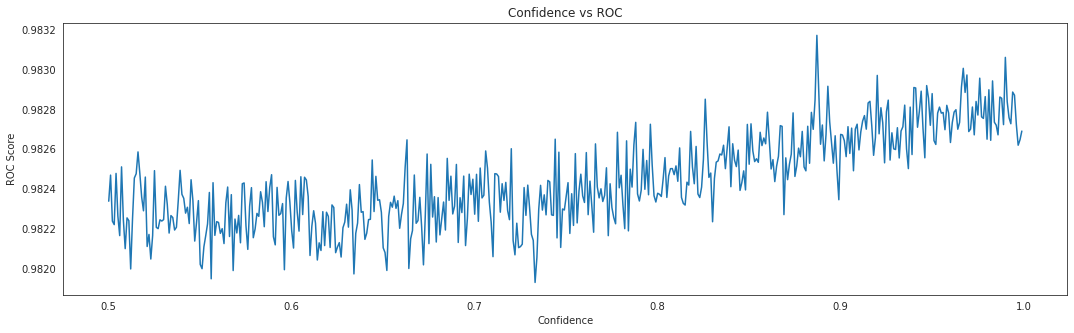

In [27]:
conf_and_roc_plot(auc_scores, nc)

We will consider probability/confidence at 0.85 begin to increase which is a good sign

**max -> ROC -> Misclassification**
1. 0.94 -> 0.9829 -> 5.3484
2. 0.996 -> 0.9827 -> 5.3132
3. 0.990 -> 0.9831 -> 5.3661
4. 0.976 -> 0.9830 -> 5.3308 -> Best
5. 0.985 -> 0.9827 -> 5.2956
6. 0.887 -> 0.9832 -> 5.3661

New Data ROC AUC LGBMClassifier Score after semi-supervised: 0.9830
'%' of Misclassified class: 5.330866155608423


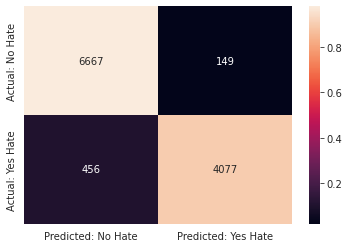

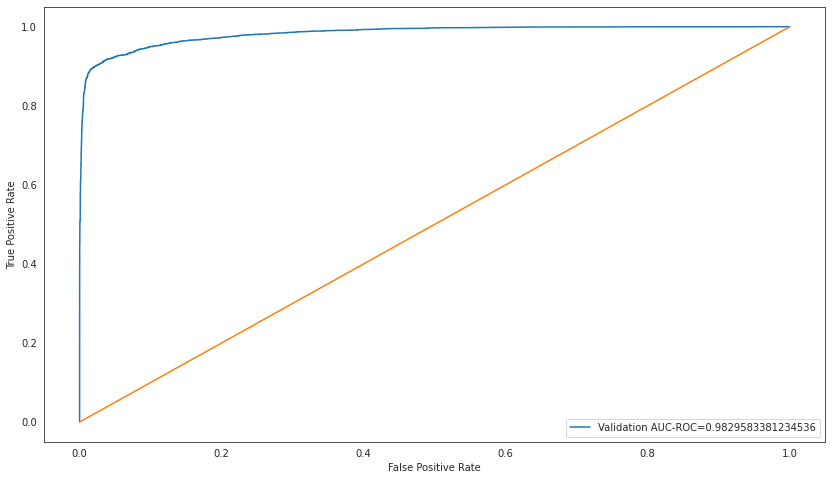

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [31]:
conf_ind=df_pseudo["max"]>0.976
X_train_new = np.append(X_train, unlabelled_cleaned[conf_ind,:],axis=0)
y_train_new = np.append(y_train, df_pseudo.loc[conf_ind, ['lab']])

pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train_new, y_train_new, X_test)

auc = roc_auc_score(y_test, pred)
print(f"New Data ROC AUC LGBMClassifier Score after semi-supervised: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [32]:
print(len(X_train))
print(len(y_train))

45396
45396


In [33]:
print(len(X_train_new))
print(len(y_train_new))

45560
45560


# Apply SMOTE to new data

In [34]:
print(X_train_new.shape)
print(y_train_new.shape)
print(Counter(y_train_new))

(45560, 1018)
(45560,)
Counter({0: 27183, 1: 18377})


In [35]:
X_train_new_ada, y_train_new_ada = ADASYN(random_state = 43).fit_resample(X_train_new, y_train_new)
print(X_train_new_ada.shape)
print(y_train_new_ada.shape)
print(Counter(y_train_new_ada))

(54663, 1018)
(54663,)
Counter({1: 27480, 0: 27183})


New Data ROC AUC LGBMClassifier Score with ADASYN: 0.9826
'%' of Misclassified class: 5.392545598731166


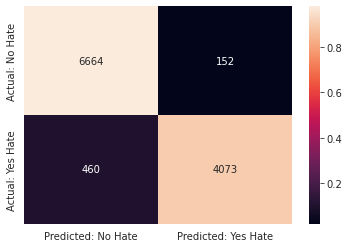

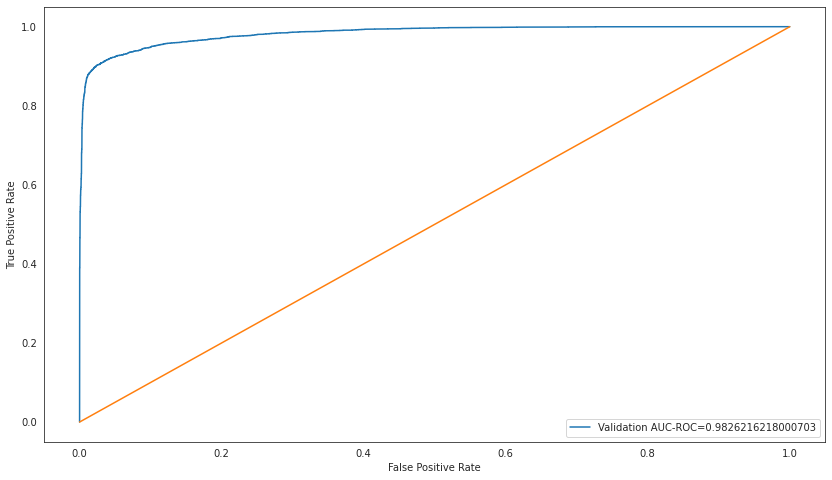

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [36]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),

                     StandardScaler(),
                     X_train_new_ada, y_train_new_ada, X_test)

auc = roc_auc_score(y_test, pred)
print(f"New Data ROC AUC LGBMClassifier Score with ADASYN: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

(54366, 1018)
(54366,)
Counter({0: 27183, 1: 27183})
New Data ROC AUC LGBMClassifier Score with BorderlineSMOTE: 0.9828
'%' of Misclassified class: 5.339677504625958


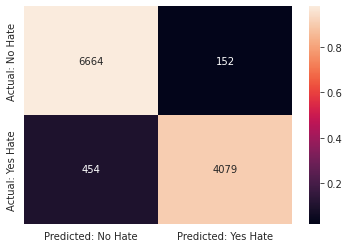

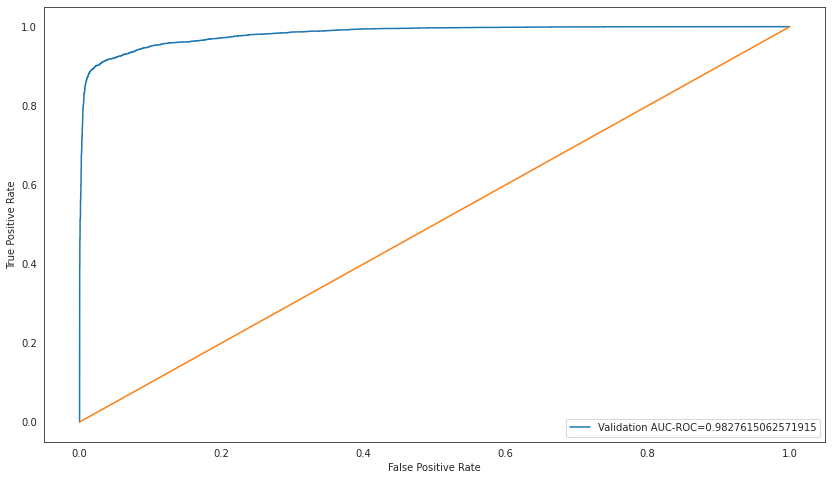

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [37]:
X_train_new_bls, y_train_new_bls = BorderlineSMOTE(random_state = 43).fit_resample(X_train_new, y_train_new)
print(X_train_new_bls.shape)
print(y_train_new_bls.shape)
print(Counter(y_train_new_bls))

pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train_new_bls, y_train_new_bls, X_test)

auc = roc_auc_score(y_test, pred)
print(f"New Data ROC AUC LGBMClassifier Score with BorderlineSMOTE: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [38]:
smote_pipe = Pipeline([('over', SMOTE(random_state = 11, sampling_strategy=0.8)),
                     ('under', RandomUnderSampler(sampling_strategy=0.9))]
                   )

X_train_new_sm, y_train_new_sm = smote_pipe.fit_resample(X_train_new, y_train_new)
print(X_train_new_sm.shape)
print(y_train_new_sm.shape)
print(Counter(y_train_new_sm))

(45908, 1018)
(45908,)
Counter({0: 24162, 1: 21746})


New Data ROC AUC LGBMClassifier Score after semi-supervised: 0.9826
'%' of Misclassified class: 5.471847739888977


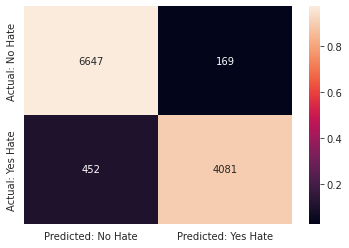

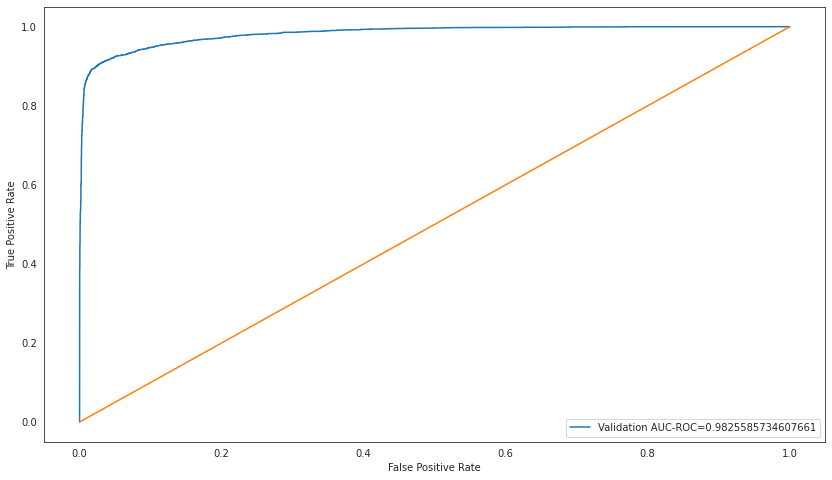

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [39]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    reg_alpha=0.01,
                                    learning_rate=0.1,
                                    objective='binary',
                                    class_weight={0:1,1:1}),
                     StandardScaler(),
                     X_train_new_sm, y_train_new_sm, X_test)

auc = roc_auc_score(y_test, pred)
print(f"New Data ROC AUC LGBMClassifier Score after semi-supervised: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

**We will consider the model with no SMOTE because of the high '%' of Misclassified class**

Final LGBMClassifer ROC AUC Score : 0.9830
'%' of Misclassified class: 5.330866155608423


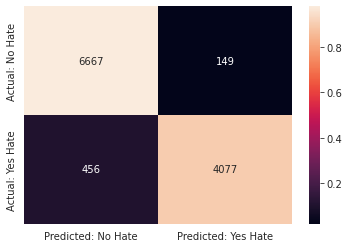

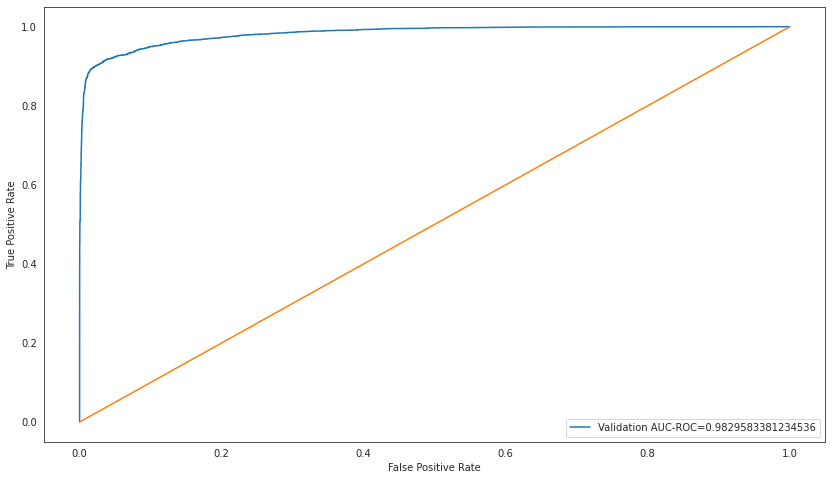

In [40]:
final_model = make_pipeline(StandardScaler(), LGBMClassifier(n_estimators=250,
                                                             reg_alpha=0.01,
                                                             learning_rate=0.1,
                                                             objective='binary',
                                                             class_weight={0:1,1:1}))

final_model.fit(X_train_new, y_train_new)
pred = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"Final LGBMClassifer ROC AUC Score : {roc_auc_score(y_test, pred):.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

In [42]:
# sns.distplot(y_pred, label='prediction')
# sns.distplot(y_train_new, label='actual')
# plt.legend()
# plt.show()

# Serialize Tfidf Vectorizer & the Final Model pipeline

In [43]:
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV6.bin', 'wb') as f:
#     joblib.dump((tfVectorizer, final_model), f)

In [44]:
with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/vectorizers/vectorizerV5.bin', 'wb') as f:
    joblib.dump(tfVectorizer, f)
    
with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV5.bin', 'wb') as f:
    joblib.dump(final_model, f)